In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:289: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:303: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact)
                                        #sakakibara_inact_kin,
                                        #sakakibara_rec)

In [5]:
modelfile = 'models/nygren_ina.mmt'

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                sakakibara_inact)
                                                #sakakibara_inact_kin_1,
                                                #sakakibara_inact_kin_100,
                                                #sakakibara_inact_kin_80,
                                                #sakakibara_rec)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

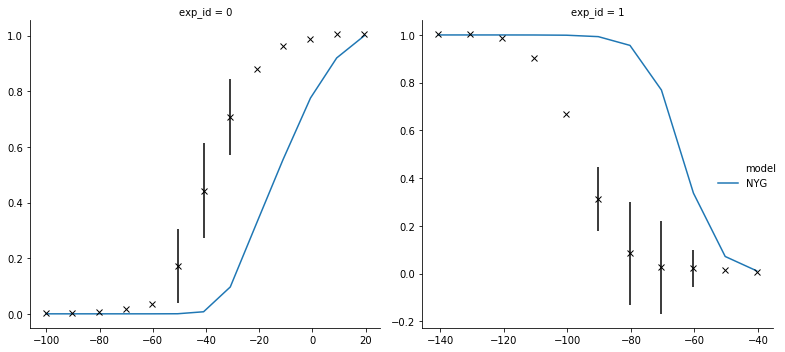

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     sakakibara_inact)
                     #sakakibara_inact_kin_1,
                     #sakakibara_inact_kin_100,
                     #sakakibara_inact_kin_80,
                     #sakakibara_rec)

In [9]:
limits = {'ina.s1': (0, 1),
          'ina.r1': (0, 200),
          'ina.r2': (0, 50),
          'ina.q1': (0, 200),
          'ina.q2': (0, 50),
          'log_ina.r3': (-6, -3),
          'ina.r4': (0, 200),
          'ina.r5': (0, 50),
          'log_ina.r6': (-6, -3),
          'log_ina.q3': (-3., 0.),
          'ina.q4': (0, 200),
          'ina.q5': (0, 50),
          'log_ina.q6': (-5, -2),
          'log_ina.q7': (-3., 0.),
          'log_ina.q8': (-4, -1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [10]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_ina_reported.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.1375036597030084, '1': 1.1375036597030084, '2': 1.1375036597030084, '3': 1.1375036597030084, '4': 1.1375036597030084, '5': 0.4313764851842987, '6': 0.33560921419107864, '7': 0.41713842292079123, '8': 1.1375036597030084, '9': 1.1375036597030084, '10': 1.1375036597030084, '11': 1.1375036597030084, '12': 1.1375036597030084, '13': 1.3443225069217373, '14': 1.3443225069217373, '15': 1.3443225069217373, '16': 1.3443225069217373, '17': 1.3443225069217373, '18': 0.5042489333570933, '19': 0.3133612496186395, '20': 0.3470799976569435, '21': 0.8658915515889136, '22': 1.3443225069217373, '23': 1.3443225069217373}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-09-26 12:59:01.985143, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2030
DEBUG:Epsilon:new eps, t=1, eps=2.1804082973753776
INFO:ABC:t:1 eps:2.1804082973753776
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 5680
DEBUG:Epsilon:new eps, t=2, eps=1.4546223067420316
INFO:ABC:t:2 eps:1.4546223067420316
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 9958
DEBUG:Epsilon:new eps, t=3, eps=1.1482409704709529
INFO:ABC:t:3 eps:1.1482409704709529
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 14645
DEBUG:Epsilon:new eps, t=4, eps=0.9334953300138503
INFO:ABC:t:4 eps:0.9334953300138503
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 19893
DEBUG:Epsilon:new eps, t=5, eps=0.81432556084

In [13]:
abc_continued = ABCSMC(models=model,
                       parameter_priors=prior,
                     distance_function=IonChannelDistance(
                         exp_id=list(observations.exp_id),
                         variance=list(observations.variance),
                         delta=0.05),
                     population_size=ConstantPopulationSize(2000),
                     summary_statistics=summary_statistics,
                     transitions=EfficientMultivariateNormalTransition(),
                     eps=MedianEpsilon(),
                     sampler=MulticoreEvalParallelSampler(n_procs=16),
                     acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.1375036597030084, '1': 1.1375036597030084, '2': 1.1375036597030084, '3': 1.1375036597030084, '4': 1.1375036597030084, '5': 0.4313764851842987, '6': 0.33560921419107864, '7': 0.41713842292079123, '8': 1.1375036597030084, '9': 1.1375036597030084, '10': 1.1375036597030084, '11': 1.1375036597030084, '12': 1.1375036597030084, '13': 1.3443225069217373, '14': 1.3443225069217373, '15': 1.3443225069217373, '16': 1.3443225069217373, '17': 1.3443225069217373, '18': 0.5042489333570933, '19': 0.3133612496186395, '20': 0.3470799976569435, '21': 0.8658915515889136, '22': 1.3443225069217373, '23': 1.3443225069217373}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [14]:
abc_continued.load(db_path, 2)

2

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=10, min_acceptance_rate=0.001)

INFO:Epsilon:initial epsilon is 0.029964270284872245
INFO:ABC:t:39 eps:0.029964270284872245
DEBUG:ABC:now submitting population 39
DEBUG:ABC:population 39 done
DEBUG:ABC:
total nr simulations up to t =39 is 1558157
DEBUG:Epsilon:new eps, t=40, eps=0.029221773716521775
INFO:ABC:t:40 eps:0.029221773716521775
DEBUG:ABC:now submitting population 40
DEBUG:ABC:population 40 done
DEBUG:ABC:
total nr simulations up to t =40 is 1905974
DEBUG:Epsilon:new eps, t=41, eps=0.02862226500524056
INFO:ABC:t:41 eps:0.02862226500524056
DEBUG:ABC:now submitting population 41


In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=10, min_acceptance_rate=0.001)

In [ ]:
history = abc_continued.run(minimum_epsilon=0., max_nr_populations=10, min_acceptance_rate=0.)

### Database results analysis

In [6]:
history = History('sqlite:////'+
                  'storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nygren/reported/nygren_ina_reported.db')

In [8]:
df, w = history.get_distribution(m=0)

In [9]:
df.describe()

name,ina.q1,ina.q2,ina.q4,ina.q5,ina.r1,ina.r2,ina.r4,ina.r5,ina.s1,log_ina.q3,log_ina.q6,log_ina.q7,log_ina.q8,log_ina.r3,log_ina.r6
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,95.869852,6.345697,32.685798,31.348783,52.335591,10.981040,108.356287,25.207283,0.511371,-1.008861,-3.521137,-0.795739,-2.490593,-4.594317,-4.042886
std,0.253810,0.144264,20.376310,10.920770,0.396146,0.336861,50.751070,13.169184,0.251496,0.756082,0.780291,0.674026,0.785998,0.773747,0.639596
min,95.231973,5.887443,0.232247,2.668423,51.155863,9.976835,0.098440,0.080851,0.001010,-2.990400,-4.996077,-2.979987,-3.995512,-5.997447,-5.995338
25%,95.681822,6.244362,17.848487,23.225371,52.059008,10.735139,68.655255,14.962322,0.305803,-1.559247,-4.159130,-1.102641,-3.137635,-5.215302,-4.475641
50%,95.846900,6.348758,30.392009,32.356481,52.332962,10.962440,109.431532,25.024219,0.521172,-0.707590,-3.512742,-0.512300,-2.469048,-4.644283,-3.936880
75%,96.034084,6.447340,44.201723,40.050534,52.613603,11.208907,150.682001,36.134104,0.721709,-0.411376,-2.882302,-0.345007,-1.865136,-3.962987,-3.530864
max,96.932710,6.729511,199.905850,49.996560,53.408465,12.040931,199.975779,49.968811,0.999701,-0.002173,-2.002168,-0.004356,-1.008455,-3.000221,-3.003726


In [22]:
cv = (1+1/(4*2000))*df.std()/abs(df.mean())

In [45]:
cv

name
ina.q1        0.002648
ina.q2        0.022737
ina.q4        0.623477
ina.q5        0.348407
ina.r1        0.007570
ina.r2        0.030680
ina.r4        0.468431
ina.r5        0.522501
ina.s1        0.491869
log_ina.q3    0.749535
log_ina.q6    0.221630
log_ina.q7    0.847150
log_ina.q8    0.315626
log_ina.r3    0.168435
log_ina.r6    0.158222
dtype: float64

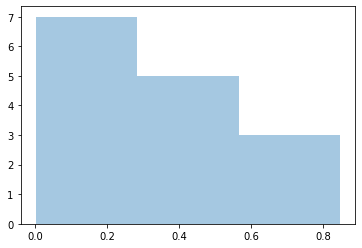

In [51]:
import seaborn as sns
sns.distplot(cv, kde=False)

In [79]:
cv

name
ina.q1        0.002648
ina.q2        0.022737
ina.q4        0.623477
ina.q5        0.348407
ina.r1        0.007570
ina.r2        0.030680
ina.r4        0.468431
ina.r5        0.522501
ina.s1        0.491869
log_ina.q3    0.749535
log_ina.q6    0.221630
log_ina.q7    0.847150
log_ina.q8    0.315626
log_ina.r3    0.168435
log_ina.r6    0.158222
dtype: float64

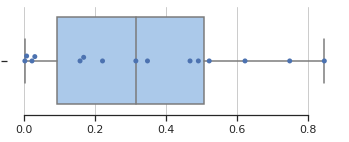

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 2))

# Plot the orbital period with horizontal boxes
sns.boxplot(cv, palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(cv)
              #size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt

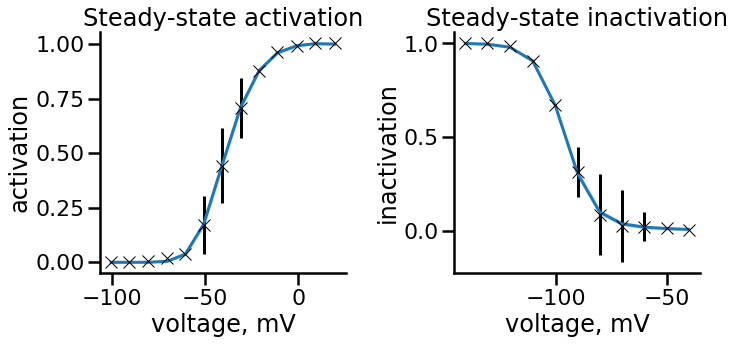

In [58]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_act,
                     sakakibara_inact,
                     df=df, w=w)

xlabels = ["voltage, mV"]*2
ylabels = ["activation", "inactivation"]
titles = ["Steady-state activation", "Steady-state inactivation"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax, t in zip(g.axes.flatten(), titles):
    ax.set_title(t)

plt.tight_layout()

In [59]:
g.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nygren/reported/model_output.pdf')

In [15]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [16]:
m,_,_ = myokit.load(modelfile)

In [17]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

In [18]:
limits.keys()

dict_keys(['ina.s1', 'ina.r1', 'ina.r2', 'ina.q1', 'ina.q2', 'log_ina.r3', 'ina.r4', 'ina.r5', 'log_ina.r6', 'log_ina.q3', 'ina.q4', 'ina.q5', 'log_ina.q6', 'log_ina.q7', 'log_ina.q8'])

In [19]:
act_params = ['ina.r1','ina.r2','log_ina.r3','ina.r4','ina.r5','log_ina.r6']

In [20]:
df_act = df[act_params]

In [21]:
limits_act = dict([(key, limits[key]) for key in act_params])

In [22]:
originals_act = dict([(key, originals[key]) for key in act_params])

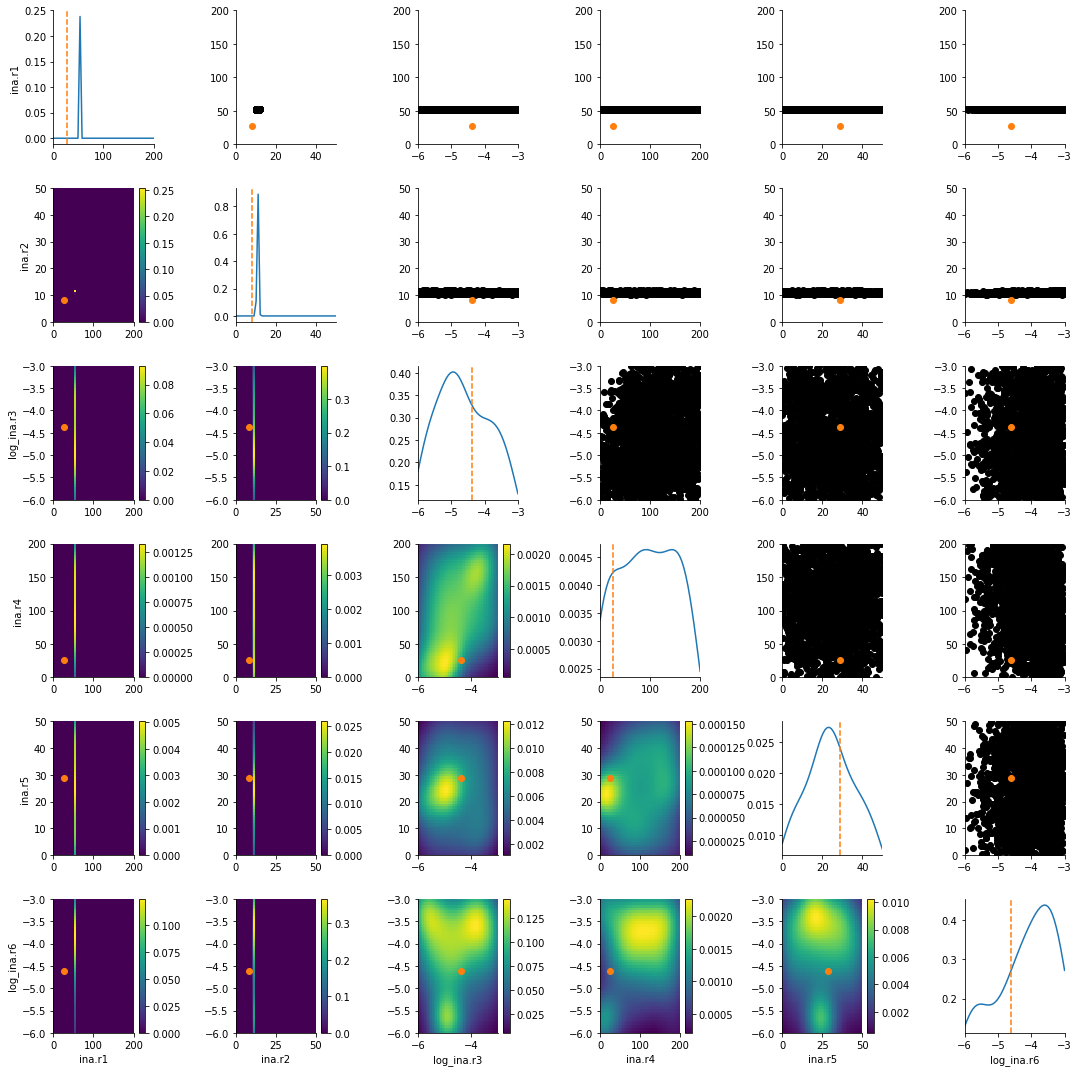

In [44]:
g = plot_kde_matrix_custom(df_act, w, limits=limits_act, refval=originals_act)

In [23]:
inact_params = ['ina.s1','ina.q1','ina.q2','log_ina.q3','ina.q4','ina.q5','log_ina.q6','log_ina.q7','log_ina.q8']

In [24]:
df_inact = df[inact_params]

In [25]:
limits_inact = dict([(key, limits[key]) for key in inact_params])

In [26]:
originals_inact = dict([(key, originals[key]) for key in inact_params])

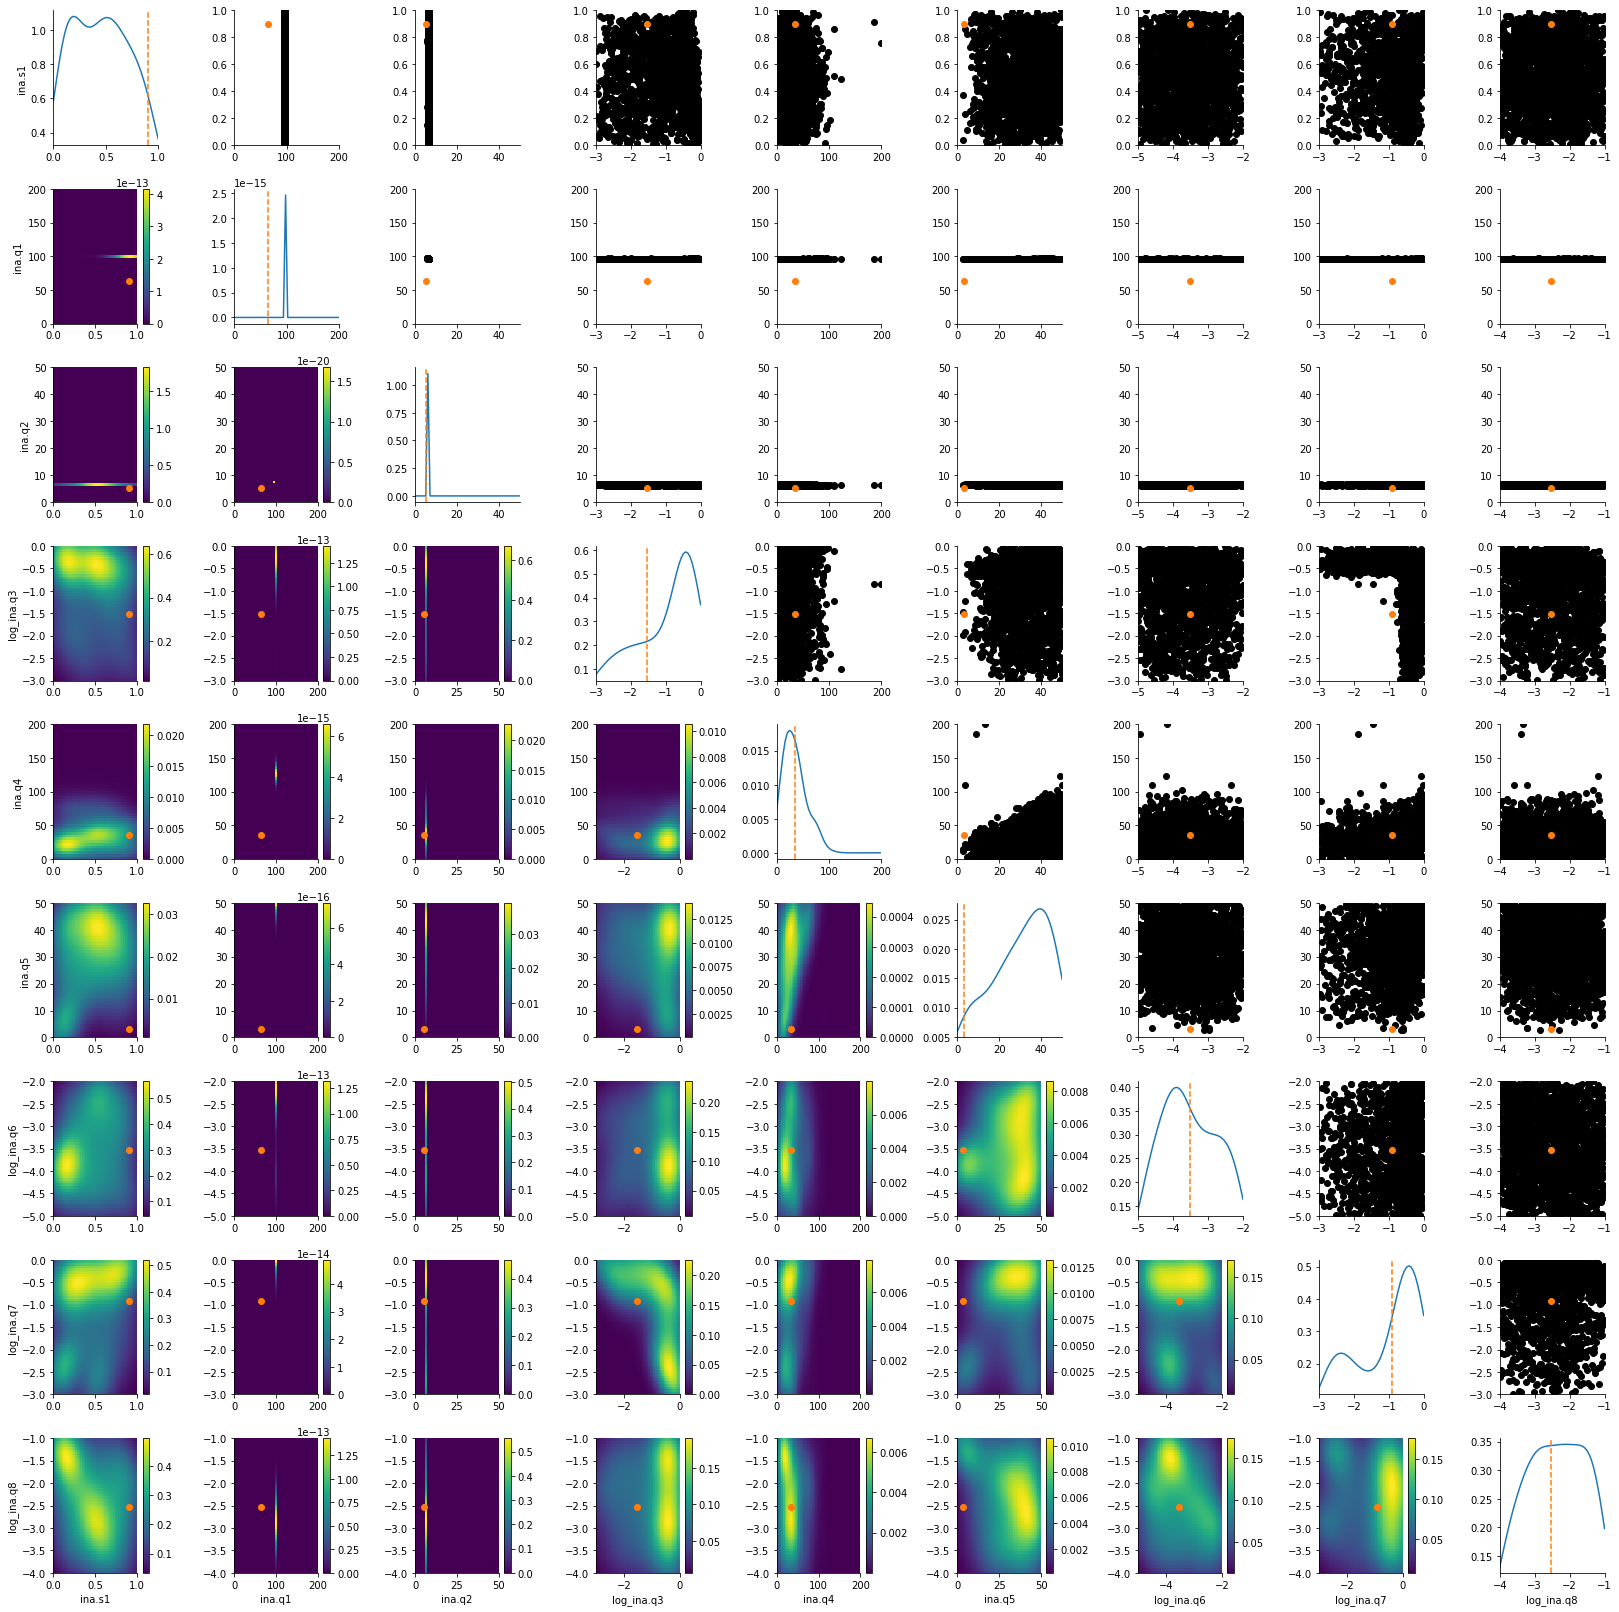

In [39]:
g = plot_kde_matrix_custom(df_inact, w, limits=limits_inact, refval=originals_inact)

In [161]:
from ionchannelABC.visualization import plot_experiment_traces

In [173]:
def split_act(data):
    out = []
    for d in data.split_periodic(11000, adjust=True):
        d = d.trim(9950, 10200, adjust=False)
        out.append(d)
    return out
def split_inact(data):
    out = []
    for d in data.split_periodic(10000, adjust=True):
        d = d.trim(9940, 10000, adjust=False)
        out.append(d)
    return out

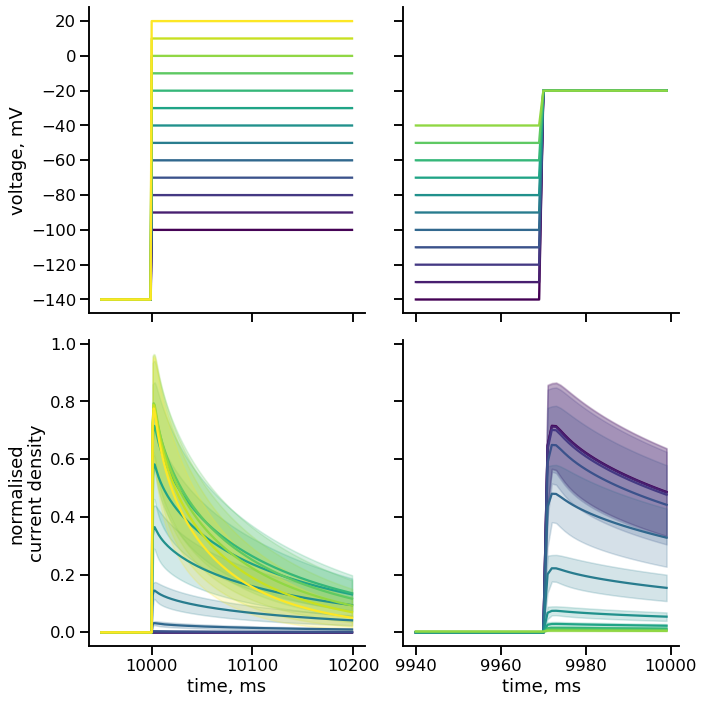

In [174]:
import seaborn as sns
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_experiment_traces(modelfile, 'ina.g', 
                           [split_act, split_inact],
                           sakakibara_act,
                           sakakibara_inact,
                           df=df, w=w, 
                           log_interval=1)

xlabel = "time, ms"
ylabels = ["voltage, mV", "normalised\ncurrent density"]
for ax in g.axes[1,:]:
    ax.set_xlabel(xlabel)
for ax, yl in zip(g.axes, ylabels):
    ax[0].set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title('')
    
plt.tight_layout()

In [172]:
g.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nygren/reported/nygren_reported_fulltraces_paper.pdf')
#g.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nygren/reported/nygren_reported_traces.pdf')

In [27]:
from pyabc.visualization import plot_kde_1d, plot_kde_2d

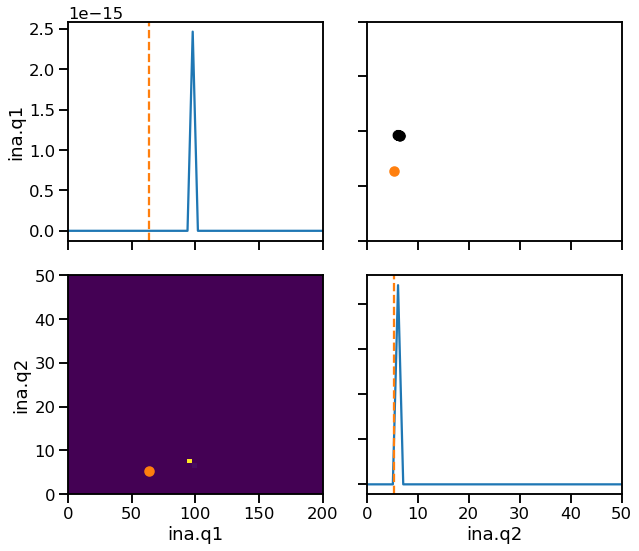

In [33]:
import seaborn as sns
sns.set_context('talk')

x = 'ina.q1'
y = 'ina.q2'

f, ax = plt.subplots(nrows=2,ncols=2,figsize=(9,8),sharex='col',sharey=False)

plot_kde_1d(df, w, x, xmin=limits[x][0], xmax=limits[x][1], refval=originals_inact, ax=ax[0][0])
plot_kde_1d(df, w, y, xmin=limits[y][0], xmax=limits[y][1], refval=originals_inact, ax=ax[1][1])

plot_kde_2d(df, w, x, y, 
            xmin=limits_inact[x][0], xmax=limits_inact[x][1],
            ymin=limits_inact[y][0], ymax=limits_inact[y][1],
            refval=originals_inact, ax=ax[1][0], colorbar=False)

alpha = w / w.max()
colors = np.zeros((alpha.size, 4))
colors[:, 3] = alpha

ax[0][1].scatter(df[y], df[x], color=colors)
ax[0][1].scatter([originals_inact[y]], [originals_inact[x]], color='C1')
ax[0][1].set_xlim(limits_inact[y])
ax[0][1].set_ylim(limits_inact[x])

# cleaning up
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel(x)
labels = [item.get_text() for item in ax[0][1].get_yticklabels()]
ax[0][1].set_yticklabels(['',]*len(labels))
ax[1][1].set_ylabel('')
labels = [item.get_text() for item in ax[1][1].get_yticklabels()]
ax[1][1].set_yticklabels(['',]*len(labels))

plt.tight_layout()

In [34]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/nygren_inact_param_q1q2_grid.pdf')